In [1]:
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten, LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import tensorflow as tf
import autokeras as ak

In [2]:
#load data
from BIAS.SB_Test_runner import get_scens_per_dim, get_simulated_data

rep = 500
n_samples = 100

scenes = get_scens_per_dim()
X = []
y = []
for scene in scenes:
    label = scene[0]
    kwargs = scene[1]
    if (label == "unif"):
        rep1 = 100 * rep
    else:
        rep1 = rep
    data = get_simulated_data(label, rep=rep1, n_samples = n_samples, kwargs=kwargs)
    for r in range(rep):
        X.append(np.sort(data[:,r]))
    if (label in ["trunc_unif", "cauchy", "norm"]):
        label = "centre"
    elif (label in ["inv_norm", "inv_cauchy","bound_thing"]):
        label = "bounds"
    elif (label in ["clusters"]):
        label = "cluster"
    elif (label in ["gaps", "part_unif"]):
        label = "gap"
    elif (label in ["spikes", "shifted_spikes"]):
        label = "disc"
    y.extend([label]*rep1)

X = np.array(X)
int_y = pd.factorize(y)[0]
targetnames = np.unique(y)

cat_y = to_categorical(int_y)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, cat_y, test_size=0.2, random_state=42, stratify=int_y)

clf = ak.StructuredDataClassifier(
    max_trials=10,
    overwrite=True,
)
# Search for the best model with EarlyStopping.
cbs = [
    tf.keras.callbacks.EarlyStopping(patience=5),
]

clf.fit(
    x=X_train,
    y=y_train,
    epochs=10,
    callbacks=cbs,
)
# Evaluate on the testing data.
print(
    "Accuracy: {accuracy}".format(
        accuracy=clf.evaluate(x=X_test, y=y_test)
    )
)

Trial 3 Complete [00h 00m 18s]
val_accuracy: 0.7053571343421936

Best val_accuracy So Far: 0.7053571343421936
Total elapsed time: 00h 00m 41s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
443/443 [==============================] - 3s 4ms/step - loss: 0.9837 - accuracy: 0.6155
Epoch 2/10
443/443 [==============================] - 2s 3ms/step - loss: 0.8130 - accuracy: 0.6907
Epoch 3/10
443/443 [==============================] - 2s 4ms/step - loss: 0.7710 - accuracy: 0.7040
Epoch 4/10
443/443 [==============================] - 2s 4ms/step - loss: 0.7406 - accuracy: 0.7161
Epoch 5/10
443/443 [==============================] - 2s 4ms/step - loss: 0.7166 - accuracy: 0.7291
Epoch 6/10
443/443 [==============================] - 2s 3ms/step - loss: 0.6957 - accuracy: 0.7364
Epoch 7/10
443/443 [==============================] - 2s 3ms/step - loss: 0.6779 - accuracy: 0.7437
Epoch 8/10
443/443 [==============================] - 2s 4ms/step - loss: 0.6590 - accuracy: 0.7509
Epoch 9/10
443/443 [

In [14]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 100)               0         
_________________________________________________________________
normalization (Normalization (None, 100)               201       
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1024)              0     

In [15]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
class newmodel(MLPClassifier):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y = self.model.predict(X)
        return np.argmax(y, axis=1)


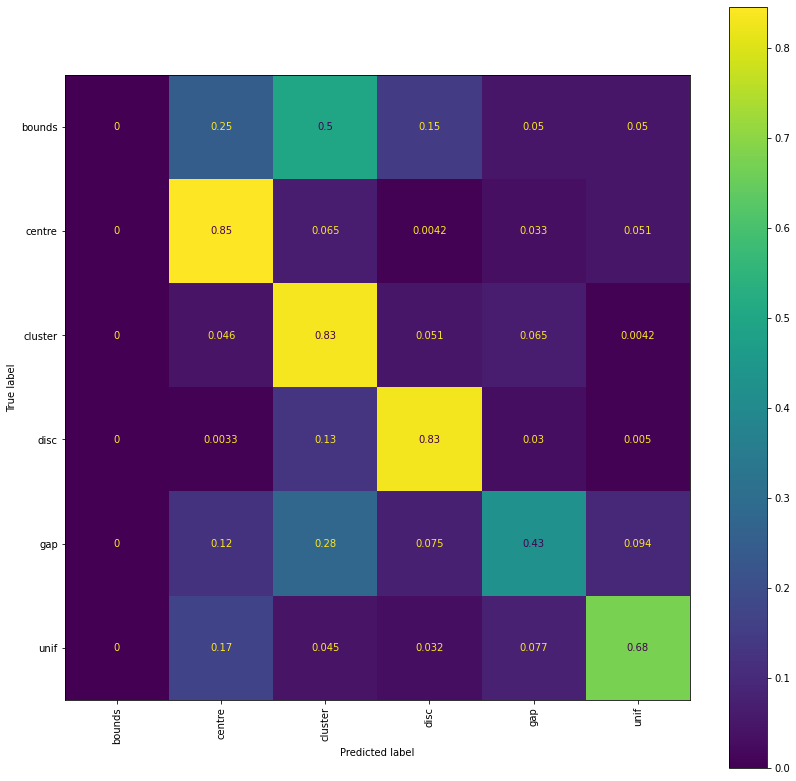

In [16]:
model1 = newmodel(model)
fig, ax = plt.subplots(figsize=(14, 14))
plot_confusion_matrix(model1, X_test, np.argmax(y_test, axis=1), normalize='true', xticks_rotation = 'vertical', display_labels = list(np.unique(targetnames)), ax=ax) 
plt.show()